# Executive Summary

#### The goal of this project is to determine if a job posting will offer a high or low salary based on its i) title; ii) company; and iii) job summary. The following steps are required to attain said goal:

#### 1. Data Acquisition
Data will be acquired by scraping information from the job aggregator site, Indeed.com. Job postings for the following roles were scraped:
* Data Scientist
* Data Analyst
* Data Engineer
* Business Intelligence
* Research Analyst

In the process of data scraping, there could be multiple instances of the same job posting - they will be removed. As a result, 3089 job postings remain, out of which only 152 contains salary information.

#### 2. Data Cleaning
The process of data cleaning is to ensure that the data is presented in a consistent format, suitable for processing, analysis, and modeling.

Text-based data is cleaned through the removal of special characters, this will help during Natural Language Processing (NLP) which will be explained later.

Most salary data are presented in a range (e.g. 5,000 - 7,000 a month), and sometimes in different time period (e.g. 80,000 - 90,000 a year). In cleaning them, the data is converted to its average, by month.

A job posting that offers high salary is defined when its average salary is greater than or equals to the median salary of 4,500 a month. Conversely, a job posting that offers low salary is defined when its average salary is lower than 4,500 a month.

#### 3. Natural Language Processing (NLP)
NLP is used that will, based on the text-based data presented, help predict if a job posting will be offering a high or low salary.

As a result of NLP, terms that are most commonly found in job postings offering high salary & low salary is found. These terms will help in distinguishing between high & low salary. Good terms are defined as terms that appear 2.5x more in job postings that offer high salary than its low salary counterparts. Vice versa for bad terms.

#### 4. Feature Engineering
Based on the insights gleaned from the previous step, the data is reconfigured to binary features:
* 1. Good_title: Does job title include the term "sales" or "executive"?
* 2. Bad_title: Does job title include the terms "data", "engineer", "software", etc.?
* 3. Good_company: Does company include the term "services" or "group"?
* 4. Bad_company: Does company include the term "asia" or "rakuten"?
* 5. Good_summary: Does job summary include the term "sales", "market", or "support"?
* 6. Bad_summary: Does job summary include the term "develop", "design", "solutions", etc.?

#### 5. Modeling and Conclusion
The Logistic Regression model is used and it is 61% accurate in predicting if job posting offers a high or low salary. After applying the model to job postings without salary information, 1515 jobs(52 percent) were predicted to offer salaries above the median salary of $4,500 while the remaining 1422 jobs(48 percent) were predicted to offer salaries below the median salary.


In [1]:
%%time
import requests
import bs4
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import string
import time

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

CPU times: user 2.02 s, sys: 768 ms, total: 2.79 s
Wall time: 6.78 s


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Web scraping

In [2]:
search_titles = ['data+scientist', 'data+analyst', 'data+engineer', 'business+intelligence', 'research+analyst']
columns = ['search_title', 'job_title', 'company_name', 'job_summary', 'salary', 'job_desc']
df = pd.DataFrame(columns=columns)

%%time #took 58mins to finish scraping
for search_title in search_titles:
    for start in range(0, 1000, 10):
        page = requests.get("https://www.indeed.com.sg/jobs?q=" + str(search_title) + "&l=Singapore" + "&start=" + str(start))
        time.sleep(0.5)
        soup = BeautifulSoup(page.text, "html.parser")
        for div in soup.find_all(name="div", attrs={"class":"row"}):
            num = (len(df) + 1)
            job_post = []
            job_post.append(search_title)

            #job title
            try:
                title = div.find(name="a", attrs={"data-tn-element":"jobTitle"}).text.strip()
                job_post.append(title)
            except:
                job_post.append("None")

            #company name
            try:    
                company = div.find(name="span", attrs={"class":"company"}).text.strip()
                job_post.append(company)
            except:
                job_post.append("None")

            #job summary
            try:
                summary = div.find("span", attrs={"class":"summary"}).text.strip()
                job_post.append(summary)
            except:
                job_post.append("None")

            #salary
            try:
                salary = div.find(name="span", attrs={"class":"no-wrap"}).text.strip()
                job_post.append(salary)
            except:
                job_post.append("None")
            
            #job description
            job_id = div["data-jk"]
            url_js = "https://www.indeed.com.sg/viewjob?jk=" + str(job_id)
            page_js = requests.get(url_js)
            soup_js = BeautifulSoup(page_js.text, "html.parser")   
            js = soup_js.find(name="div", attrs={"class":"jobsearch-JobComponent-description"}).text.strip()
            job_post.append(js)
            
            df.loc[num] = job_post

In [3]:
df = pd.read_csv('./dataset.csv', index_col='Unnamed: 0')
df = df[['job_title', 'company_name', 'job_summary', 'job_desc', 'salary']]

In [4]:
print("Out of {} job postings, only {}({}%) contains salary data.".format(
    len(df['salary']), 
    len(df.loc[df['salary'] != "None"]), 
    np.round(len(df.loc[df['salary'] != "None"])/len(df['salary'])*100,2)
))

Out of 7622 job postings, only 587(7.7%) contains salary data.


# Data cleaning

In [5]:
#defining a function that removes special characters
def string_clean(df, col):
    for item in string.punctuation:
        df[col] = df[col].apply(lambda x: x.replace(item," ").replace("\n", " ").lower())

In [6]:
#dropping duplicates
df = df.drop_duplicates()

#removing rows with "None" value (except salary)
for col in df.columns[0:-1]:
    df = df[df[col] != "None"]
    string_clean(df,col)
    
df = df.reset_index(drop=True)

In [7]:
df

,job_title,company_name,job_summary,job_desc,salary
0,a i machine learning engineer scientist,a i hub singapore http www aihub sg,machine learning engineer scientist achieveme...,5 000 7 000 a montha i hub singapore htt...,"$5,000 - $7,000 a month"
1,data scientist,rio tinto,we are looking for a data scientist to be resp...,data scientist great opportunity to work with...,None
2,data science manager,indeed,significant prior success as a data scientist ...,our mission as the world’s number 1 job site ...,None
3,data scientist,datasearch consulting,extract insights and actionable recommendation...,our client an emerging financial technology v...,None
4,data scientist,rakuten asia pte ltd,solid experience in advanced data analytics b...,5 000 9 000 a monthpermanentresponsibiliti...,"$5,000 - $9,000 a month"
5,senior data scientist,sense infosys pte ltd,using data modeling linear regression statis...,working closely with the product manager the ...,None
6,data scientist,snaphunt,ability to visualize data with the aid of data...,80 000 100 000 a yearpermanentthe employer...,"$80,000 - $100,000 a year"
7,data scientist,apple,researches and if applicable implements new ...,summary posted sep 27 2018 weekly hours 40 ...,None
8,data engineers,sense infosys pte ltd,create data tools for analytics and data scien...,create and maintain optimal data pipeline arch...,None
9,data scientist,dow technologies and systems,design efficient scalable automated processe...,5 500 8 000 a monthjob summary·use machine...,"$5,500 - $8,000 a month"


In [34]:
print("After cleaning, out of {} job postings, only {}({}%) contains salary data.".format(
    len(df['salary']), 
    len(df.loc[df['salary'] != "None"]), 
    np.round(len(df.loc[df['salary'] != "None"])/len(df['salary'])*100,2)
))

After cleaning, out of 3089 job postings, only 152(4.92%) contains salary data.


### Getting data with salary

In [8]:
sal = df[df['salary'] != "None"].reset_index(drop=True)

In [9]:
for i in sal['salary'].unique():
    print(i)
    
# salary is either by month or by year

$5,000 - $7,000 a month
$5,000 - $9,000 a month
$80,000 - $100,000 a year
$5,500 - $8,000 a month
$1,200 a month
$8,000 - $15,000 a month
$3,800 - $4,800 a month
$2,000 - $3,000 a month
$4,500 - $6,500 a month
$5,000 - $8,000 a month
$4,500 - $8,000 a month
$4,000 - $6,000 a month
$6,000 - $8,000 a month
$2,500 - $3,500 a month
$3,500 - $4,500 a month
$3,000 - $3,600 a month
$42,000 - $60,000 a year
$4,500 - $6,000 a month
$2,800 - $3,000 a month
$2,800 - $4,500 a month
$3,500 - $6,000 a month
$2,000 - $3,500 a month
$2,500 - $4,000 a month
$3,000 - $5,500 a month
$4,500 - $5,800 a month
$3,500 - $5,000 a month
$3,600 - $4,600 a month
$4,000 - $7,000 a month
$4,000 - $5,000 a month
$3,600 - $4,000 a month
$5,000 - $7,500 a month
$2,900 - $3,000 a month
$4,500 - $7,500 a month
$3,200 - $3,500 a month
$1,800 - $2,700 a month
$3,500 - $4,000 a month
$7,000 - $8,300 a month
$2,800 - $4,000 a month
$4,000 - $8,000 a month
$4,000 a month
$8,000 - $10,000 a month
$5,000 - $6,500 a month
$2,20

In [10]:
#engineering a feature that tells me salary period
sal['period'] = sal['salary'].apply(lambda x: x.split(" a ")[-1])

#engineering averaged salary by month
sal['salary'] = sal['salary'].apply(lambda x: 
                                    x.replace("$", "")
                                    .replace(",", "")
                                    .replace(" a month", "")
                                    .replace(" a year", ""))
sal['sal_start_range'] = sal['salary'].apply(lambda x: x.split(" - ")[0]).astype(int)
sal['sal_end_range'] = sal['salary'].apply(lambda x: x.split(" - ")[-1]).astype(int)
sal['avg_salary'] = (sal['sal_start_range'] + sal['sal_end_range']) / 2
sal.loc[sal['period'] == 'year', 'avg_salary'] = sal.loc[sal['period'] == 'year', 'avg_salary'] / 12
sal = sal[['job_title', 'company_name', 'job_summary', 'job_desc', 'avg_salary']]

In [11]:
print("The median salary is {}".format(sal['avg_salary'].median()))

The median salary is 4500.0


In [12]:
#engineering an is_high column to determine whether salary is high
sal['is_high'] = sal['avg_salary'].apply(lambda x: 1 if x >= sal['avg_salary'].median() else 0)

In [13]:
sal

,job_title,company_name,job_summary,job_desc,avg_salary,is_high
0,a i machine learning engineer scientist,a i hub singapore http www aihub sg,machine learning engineer scientist achieveme...,5 000 7 000 a montha i hub singapore htt...,6000.0,1
1,data scientist,rakuten asia pte ltd,solid experience in advanced data analytics b...,5 000 9 000 a monthpermanentresponsibiliti...,7000.0,1
2,data scientist,snaphunt,ability to visualize data with the aid of data...,80 000 100 000 a yearpermanentthe employer...,7500.0,1
3,data scientist,dow technologies and systems,design efficient scalable automated processe...,5 500 8 000 a monthjob summary·use machine...,6750.0,1
4,data scientist intern,smartease,candidates who have completed a 12 week bootca...,1 200 a monthinternshipthis is a 8 week full ...,1200.0,0
5,senior data scientist,rakuten asia pte ltd,solid experience in advanced data analytics b...,8 000 15 000 a monthpermanentresponsibilit...,11500.0,1
6,scientist molecular biology,thermo fisher scientific,the scientist ii will possess the technical ca...,3 800 4 800 a monthpermanentabout the role...,4300.0,0
7,bioinformatics scientist,igene laboratory,full biological information from next generati...,2 000 3 000 a monthpermanentjob summarythe...,2500.0,0
8,research engineer,rakuten asia pte ltd,design and develop scalable data platform wit...,5 000 9 000 a monthpermanentresponsibility...,7000.0,1
9,material polymer scientist,structo pte ltd,construct experimental studies intended to pro...,4 500 6 500 a monthresponsibilities devel...,5500.0,1


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


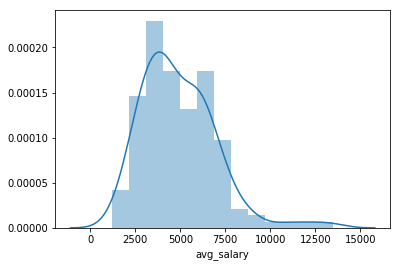

In [14]:
sns.distplot(sal['avg_salary'])

In [15]:
sal_X = sal.iloc[:,:-2]
sal_y = sal['is_high']

In [16]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(sal_X, sal_y, test_size=0.2, stratify=sal_y, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [18]:
def insights(col):
    cvec = CountVectorizer(stop_words='english',ngram_range=(1, 3), min_df = .05)
    cvec.fit(X_train[col])
    col_train = pd.DataFrame(cvec.transform(X_train[col]).todense(), columns=cvec.get_feature_names())
    word_observe = pd.concat([col_train, y_train], axis=1)
    high_sal_words = word_observe[word_observe['is_high'] == 1].sum()
    low_sal_words = word_observe[word_observe['is_high'] == 0].sum()
    comparison_table = pd.DataFrame([high_sal_words, low_sal_words]).T
    comparison_table['ratio'] = comparison_table[1] / comparison_table[0]
    return comparison_table['ratio'].sort_values(ascending=False)

In [19]:
insights('job_title')

sales                7.000000
executive            6.000000
research             1.666667
business             1.500000
analyst              1.470588
business analyst     0.600000
data                 0.333333
engineer             0.318182
senior               0.250000
scientist            0.142857
software             0.076923
is_high              0.000000
software engineer    0.000000
lead                 0.000000
Name: ratio, dtype: float64

In [20]:
insights('company_name')

services            2.500000
group               2.500000
singapore           1.400000
pte                 0.937500
international       0.750000
asia                0.142857
is_high             0.000000
rakuten asia pte    0.000000
rakuten asia        0.000000
rakuten             0.000000
asia pte            0.000000
Name: ratio, dtype: float64

In [21]:
insights('job_summary')

sales                    7.000000
market                   3.750000
support                  3.500000
customer                 2.333333
provide                  2.000000
analysis                 1.500000
development              1.400000
marketing                1.250000
intelligence             1.111111
business                 1.045455
client                   0.800000
data                     0.735294
work                     0.714286
analyst                  0.666667
business intelligence    0.666667
team                     0.625000
research                 0.588235
engineer                 0.461538
develop                  0.333333
design                   0.333333
solutions                0.285714
experience               0.235294
products                 0.166667
software                 0.142857
analytics                0.100000
data analytics           0.000000
is_high                  0.000000
Name: ratio, dtype: float64

Based on insights generated above, terms with ratio of >= 2.5 is considered good while terms with ratio of <=0.4 is considered bad

# Feature engineering

In [22]:
sal_X['good_job_title'] = sal_X['job_title'].apply(lambda x: 1 if "sales" in x else 1 if "executive" in x else 0)
sal_X['bad_job_title'] = sal_X['job_title'].apply(lambda x: 1 if "data" in x else 1 if "engineer" in x else 1 if "senior" in x else 1 if "scientist" in x else 1 if "software" in x else 1 if "lead" in x else 0)
sal_X['good_company'] = sal_X['company_name'].apply(lambda x: 1 if "services" in x else 1 if "group" in x else 0)
sal_X['bad_company'] = sal_X['company_name'].apply(lambda x: 1 if "asia" in x else 1 if "rakuten" in x else 0)
sal_X['good_summary'] = sal_X['job_summary'].apply(lambda x: 1 if "sales" in x else 1 if "market" in x else 1 if "support" in x else 0)
sal_X['bad_summary'] = sal_X['job_title'].apply(lambda x: 1 if "develop" in x else 1 if "design" in x else 1 if "solutions" in x else 1 if "experience" in x else 1 if "products" in x else 1 if "software" in x else 1 if "analytics" in x else 0)

In [23]:
sal_X = sal_X[['good_job_title','bad_job_title','good_company','bad_company','good_summary','bad_summary']].astype(float)

In [24]:
sal_X

,good_job_title,bad_job_title,good_company,bad_company,good_summary,bad_summary
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,1.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,1.0,0.0,0.0
9,0.0,1.0,0.0,0.0,1.0,0.0


In [25]:
sal_y = sal_y.values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(sal_X, sal_y, test_size=0.2, stratify=sal_y, random_state=42)

# Modeling

In [27]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
print ("Score:", nb.score(X_train, y_train))
scores = cross_val_score(nb, X_train, y_train, cv=6)
print ("Cross-validated scores:", scores)

Score: 0.6776859504132231
Cross-validated scores: [0.66666667 0.66666667 0.66666667 0.6        0.78947368 0.63157895]


In [28]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print ("Score:", logreg.score(X_train, y_train))
scores = cross_val_score(logreg, X_train, y_train, cv=6)
print ("Cross-validated scores:", scores)

Score: 0.743801652892562
Cross-validated scores: [0.80952381 0.71428571 0.76190476 0.7        0.84210526 0.57894737]


In [29]:
y_probs = logreg.predict(X_test)   
print("Score:", logreg.score(X_test, y_test))

print(confusion_matrix(y_test, y_probs))


target_names = ['below_med', 'above_med']
print(classification_report(y_test, y_probs, target_names=target_names))

Score: 0.6129032258064516
[[ 9  6]
 [ 6 10]]
             precision    recall  f1-score   support

  below_med       0.60      0.60      0.60        15
  above_med       0.62      0.62      0.62        16

avg / total       0.61      0.61      0.61        31



# Predicting

In [30]:
#dataframe without salary data
predict_data = df[df['salary'] == "None"].reset_index(drop=True)
predict_data

,job_title,company_name,job_summary,job_desc,salary
0,data scientist,rio tinto,we are looking for a data scientist to be resp...,data scientist great opportunity to work with...,None
1,data science manager,indeed,significant prior success as a data scientist ...,our mission as the world’s number 1 job site ...,None
2,data scientist,datasearch consulting,extract insights and actionable recommendation...,our client an emerging financial technology v...,None
3,senior data scientist,sense infosys pte ltd,using data modeling linear regression statis...,working closely with the product manager the ...,None
4,data scientist,apple,researches and if applicable implements new ...,summary posted sep 27 2018 weekly hours 40 ...,None
5,data engineers,sense infosys pte ltd,create data tools for analytics and data scien...,create and maintain optimal data pipeline arch...,None
6,junior back end engineer,pencil,working with front end engineers and data scie...,we re looking for a junior back end engineer w...,None
7,senior data scientist dil,axa,we have gathered both the latest data science ...,the axa group a worldwide leader in insurance...,None
8,research engineer,titansoft singapore,knowledge and experience in data visualisation...,are you someone who instead of searching for t...,None
9,associate scientist junior scientist scientist,vela diagnostics,design and develop innovative products for nex...,design and develop innovative products for nex...,None


In [31]:
#performing the same feature engineering steps for dataframe without salary data
predict_data['good_job_title'] = predict_data['job_title'].apply(lambda x: 1 if "sales" in x else 1 if "executive" in x else 0)
predict_data['bad_job_title'] = predict_data['job_title'].apply(lambda x: 1 if "data" in x else 1 if "engineer" in x else 1 if "senior" in x else 1 if "scientist" in x else 1 if "software" in x else 1 if "lead" in x else 0)
predict_data['good_company'] = predict_data['company_name'].apply(lambda x: 1 if "services" in x else 1 if "group" in x else 0)
predict_data['bad_company'] = predict_data['company_name'].apply(lambda x: 1 if "asia" in x else 1 if "rakuten" in x else 0)
predict_data['good_summary'] = predict_data['job_summary'].apply(lambda x: 1 if "sales" in x else 1 if "market" in x else 1 if "support" in x else 0)
predict_data['bad_summary'] = predict_data['job_title'].apply(lambda x: 1 if "develop" in x else 1 if "design" in x else 1 if "solutions" in x else 1 if "experience" in x else 1 if "products" in x else 1 if "software" in x else 1 if "analytics" in x else 0)

predict_X = predict_data[['good_job_title','bad_job_title','good_company','bad_company','good_summary','bad_summary']].astype(float)
predict_data = predict_data[['job_title','company_name','job_summary','job_desc']]

In [32]:
predict_y = logreg.predict(predict_X)   
predict_data["salary_prediction"] = predict_y

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
print("Based on the Logistic Regression model, when applied to the remaining job postings without salary data, \n{} jobs({}%) were predicted to offer salaries above the median salary of $4,500 \nwhile the remaining {} jobs({}%) were predicted to offer salaries below the median salary."
      .format(predict_data['salary_prediction'].sum(), 
              np.round(predict_data['salary_prediction'].sum() / len(predict_data['salary_prediction']) * 100),
              len(predict_data['salary_prediction']) - predict_data['salary_prediction'].sum(),
              np.round((1 - (predict_data['salary_prediction'].sum() / len(predict_data['salary_prediction']))) * 100)
             ))

Based on the Logistic Regression model, when applied to the remaining job postings without salary data, 
1515 jobs(52.0%) were predicted to offer salaries above the median salary of $4,500 
while the remaining 1422 jobs(48.0%) were predicted to offer salaries below the median salary.
